In [256]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from imblearn.over_sampling import SMOTE
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns
from patsy import dmatrices
from sklearn.metrics import confusion_matrix
from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import lightgbm as lgb
import operator
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import (StratifiedKFold, cross_val_score,
                                      train_test_split)

In [2]:
cnx = create_engine('postgresql://postgres@54.193.102.87:5432/instacartdb')

In [3]:
sliced_user = pd.read_sql_query('''select * from sliced_data''',cnx)

In [4]:
sliced_user.head()

,product_id,product_name,aisle_id,add_to_cart_order,reordered,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department_id
0,35958,Dairy Free Original Coconutmilk Coffee Creamer,91,1,0,2381136,137454,prior,1,3.0,10.0,NaN,16
1,13889,Cashew Milk Salted Caramel Cluster Non-Dairy F...,37,3,0,2381136,137454,prior,1,3.0,10.0,NaN,1
2,27104,Fresh Cauliflower,83,4,0,2381136,137454,prior,1,3.0,10.0,NaN,4
3,18598,Expeller Pressed Coconut Oil Spray,19,5,0,2381136,137454,prior,1,3.0,10.0,NaN,13
4,19448,Organic Gluten Free & Wheat Free Pumpkin Spice...,52,6,0,2381136,137454,prior,1,3.0,10.0,NaN,1


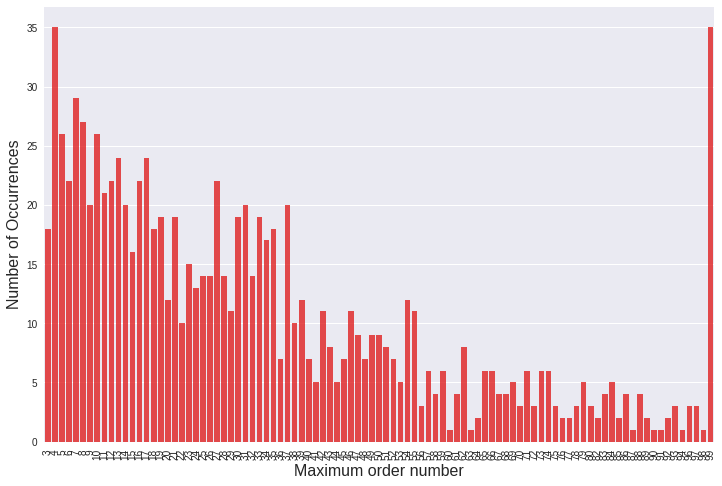

In [383]:
cnt_srs = sliced_user.groupby(['user_id'])['order_number'].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.8, color='Red')
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Maximum order number', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

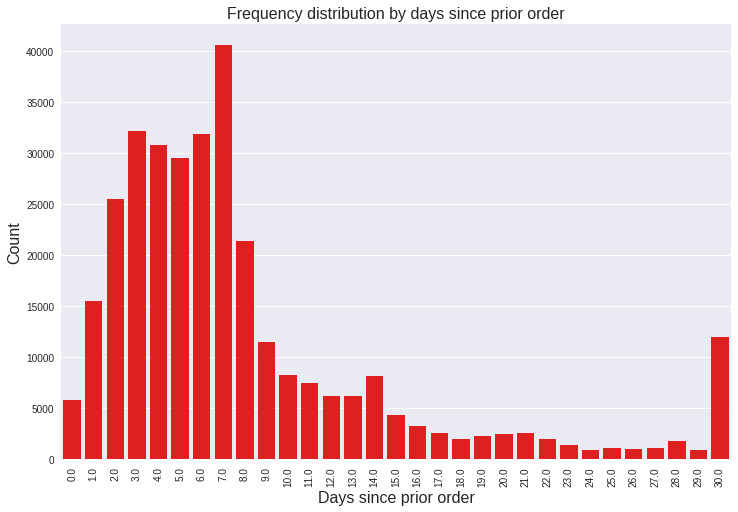

In [384]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=sliced_user, color='Red')
plt.ylabel('Count', fontsize=16)
plt.xlabel('Days since prior order', fontsize=16)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=16)
plt.show()

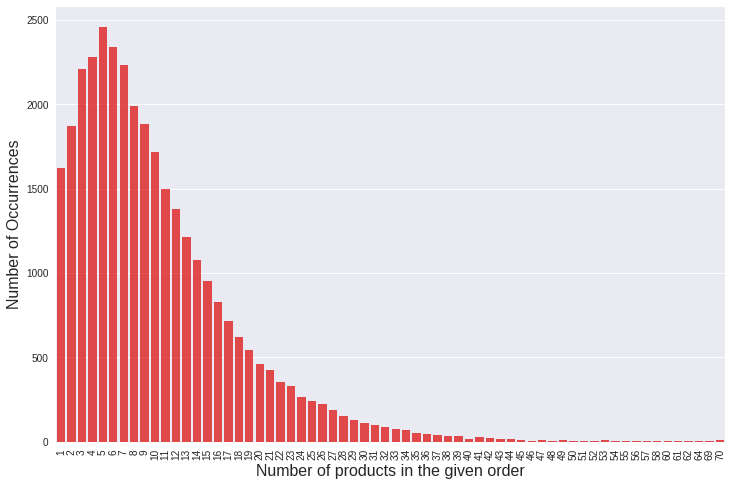

In [385]:
grouped_df = sliced_user.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='Red')
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Number of products in the given order', fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

/home/kalgi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


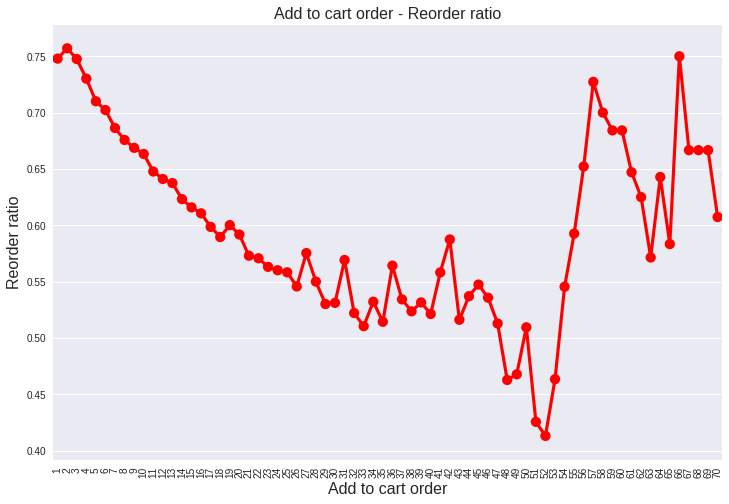

In [386]:
sliced_user["add_to_cart_order"].ix[sliced_user["add_to_cart_order"]>70] = 70
grouped_df = sliced_user.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order'].values, grouped_df['reordered'].values, alpha=0.8, color='Red')
plt.ylabel('Reorder ratio', fontsize=16)
plt.xlabel('Add to cart order', fontsize=16)
plt.title("Add to cart order - Reorder ratio", fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

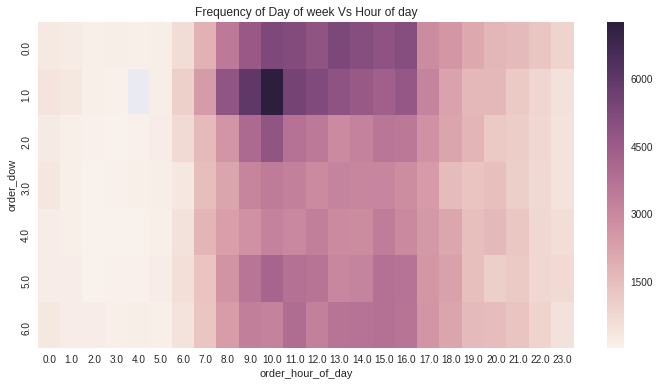

In [77]:
time_orders = sliced_user.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
time_orders = time_orders.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(time_orders)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

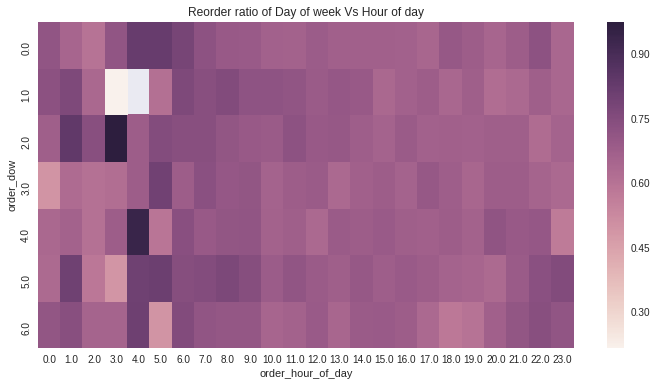

In [76]:
time_heat = sliced_user.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
time_heat = time_heat.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(time_heat)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

In [306]:
def user_feature_cart_size(sliced_user):
    agg_map = {
    'days_since_prior_order' : np.median,
    'order_number' : np.max}
    #order = sliced_user.groupby(['user_id','order_id']).agg(agg_map).reset_index()
    order = sliced_user.groupby(['user_id']).agg(agg_map).reset_index()
    order.rename(columns={'days_since_prior_order' : 'user_days_prior'}, inplace=True)
    return order

In [307]:
u_features = user_feature_cart_size(sliced_user)
u_features.head(10)

,user_id,user_days_prior,order_number
0,435,14.0,13
1,601,6.0,9
2,913,12.0,27
3,1143,30.0,3
4,1201,28.0,6
5,1496,8.0,24
6,1610,14.0,11
7,1834,21.0,5
8,1837,3.0,88
9,1951,7.0,35


In [308]:
def user_product_features(sliced_user):
    agg_map = {
    'product_name' : np.count_nonzero,
    'reordered' : np.sum,
    'days_since_prior_order' : np.median,
    'order_dow' : np.median, 
    'order_hour_of_day' : np.median,
    'add_to_cart_order' : np.median,}
    user_product = sliced_user.groupby(['user_id','product_id']).agg(agg_map).reset_index()
    user_product.rename(columns={'product_name' : 'user_product_count'}, inplace=True)
    return user_product

In [309]:
up_features = user_product_features(sliced_user)
up_features.head(10)

,user_id,product_id,user_product_count,reordered,days_since_prior_order,order_dow,order_hour_of_day,add_to_cart_order
0,435,77,3,2,12.0,2.0,20.0,9.0
1,435,812,10,9,14.0,1.0,18.0,5.0
2,435,2050,1,0,13.0,1.0,14.0,10.0
3,435,2489,1,0,28.0,1.0,18.0,14.0
4,435,2960,4,3,17.0,1.0,17.5,8.5
5,435,3016,1,0,28.0,1.0,18.0,16.0
6,435,3491,1,0,7.0,1.0,16.0,5.0
7,435,4588,1,0,12.0,2.0,20.0,11.0
8,435,7676,10,9,14.0,1.0,18.0,3.0
9,435,7969,1,0,14.0,2.0,12.0,9.0


In [310]:
def product_features(sliced_user):
    products = pd.read_csv('/home/kalgi/ds/metis/projects/McNulty/data_files/products.csv')
    aisles = pd.read_csv('/home/kalgi/ds/metis/projects/McNulty/data_files/aisles.csv')
    departments = pd.read_csv('/home/kalgi/ds/metis/projects/McNulty/data_files/departments.csv')
    product_aisles = products.merge(aisles, how='left', left_on='aisle_id', right_on='aisle_id')
    product_aisles_dept = product_aisles.merge(departments, how='left', left_on='department_id', right_on='department_id')
    agg_map = {
    'product_name' : np.count_nonzero}
    product_count = sliced_user.groupby(['product_id']).agg(agg_map).reset_index()
    product_count.rename(columns={'product_name' : 'global_product_count'}, inplace=True)
    product_features = product_aisles_dept.merge(product_count, how='inner', left_on='product_id', right_on='product_id')
    return product_features
    #products['percent_prod'] = (products['product_name_x'] / products['product_name_y']) *100

In [311]:
p_features = product_features(sliced_user)
p_features.head(10)

,product_id,product_name,aisle_id,department_id,aisle,department,global_product_count
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,12
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,8
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,10
3,8,Cut Russet Potatoes Steam N' Mash,116,1,frozen produce,frozen,2
4,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7,water seltzer sparkling water,beverages,39
5,12,Chocolate Fudge Layer Cake,119,1,frozen dessert,frozen,1
6,18,Pizza for One Suprema Frozen Pizza,79,1,frozen pizza,frozen,3
7,23,Organic Turkey Burgers,49,12,packaged poultry,meat seafood,18
8,24,Tri-Vi-Sol® Vitamins A-C-and D Supplement Drop...,47,11,vitamins supplements,personal care,1
9,25,Salted Caramel Lean Protein & Fiber Bar,3,19,energy granola bars,snacks,15


In [312]:
merged_up_features = up_features.merge(u_features, how='inner', left_on='user_id', right_on='user_id')
merged_up_features = merged_up_features.merge(p_features, how='inner', left_on='product_id', right_on='product_id')
merged_up_features.head()

,user_id,product_id,user_product_count,reordered,days_since_prior_order,order_dow,order_hour_of_day,add_to_cart_order,user_days_prior,order_number,product_name,aisle_id,department_id,aisle,department,global_product_count
0,435,77,3,2,12.0,2.0,20.0,9.0,14.0,13,Coconut Chocolate Chip Energy Bar,3,19,energy granola bars,snacks,5
1,29533,77,2,1,5.0,4.0,10.5,11.5,6.0,51,Coconut Chocolate Chip Energy Bar,3,19,energy granola bars,snacks,5
2,435,812,10,9,14.0,1.0,18.0,5.0,14.0,13,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,43
3,22614,812,6,5,6.5,3.0,10.5,17.0,7.0,47,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,43
4,35314,812,2,1,7.0,3.5,17.5,29.0,8.0,40,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,43


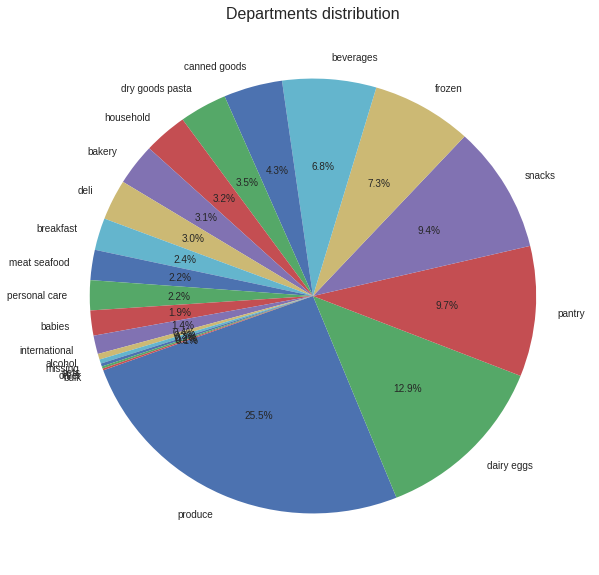

In [387]:
plt.figure(figsize=(10,10))
temp_series = merged_up_features['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=16)
plt.show()

In [314]:
def get_target_df():
    target = pd.read_sql_query('''
    select product_id, user_id, orders_train.order_id
    from orders_train left join orders_user on orders_train.order_id = orders_user.order_id
    where user_id in (select distinct user_id from sliced_data)
    ''',cnx)
    return target

In [315]:
def get_test_df():
    target = pd.read_sql_query('''
    select product_id, user_id, orders_test.order_id
    from orders_test left join orders_user on orders_test.order_id = orders_user.order_id
    where user_id in (select distinct user_id from sliced_data)
    ''',cnx)
    return target

In [316]:
target = get_target_df()
target['label'] = 1

m = pd.merge(merged_up_features, target, how='left', left_on=['user_id', 'product_id'], right_on=['user_id','product_id'])

m['label'] = m['label'].fillna(0)
m['order_id'] = m['order_id'].fillna(0)
m.head()

,user_id,product_id,user_product_count,reordered,days_since_prior_order,order_dow,order_hour_of_day,add_to_cart_order,user_days_prior,order_number,product_name,aisle_id,department_id,aisle,department,global_product_count,order_id,label
0,435,77,3,2,12.0,2.0,20.0,9.0,14.0,13,Coconut Chocolate Chip Energy Bar,3,19,energy granola bars,snacks,5,0.0,0.0
1,29533,77,2,1,5.0,4.0,10.5,11.5,6.0,51,Coconut Chocolate Chip Energy Bar,3,19,energy granola bars,snacks,5,0.0,0.0
2,435,812,10,9,14.0,1.0,18.0,5.0,14.0,13,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,43,1101383.0,1.0
3,22614,812,6,5,6.5,3.0,10.5,17.0,7.0,47,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,43,0.0,0.0
4,35314,812,2,1,7.0,3.5,17.5,29.0,8.0,40,Healthy Grains Oats & Honey Clusters with Toas...,57,14,granola,breakfast,43,0.0,0.0


In [317]:
m.groupby(['label']).size()

label
0.0    99790
1.0     4922
dtype: int64

In [367]:
y_log = m['label']
X_train_full, X_test_full, y_train, y_test = train_test_split(m, y_log, test_size=0.3, random_state=42)

X_train_dummy = pd.get_dummies(data = X_train_full, columns = ['aisle','department'])
X_test_dummy = pd.get_dummies(data = X_test_full, columns = ['aisle','department'])

X_train_dummy.fillna(0)
X_test_dummy.fillna(0)

list_columns = list(X_train_dummy.columns)
delete = ['user_id','product_id','label','aisle_id','department_id','product_name', 'order_id']
new_list = []
for columns in list_columns:
    if columns not in delete:
        new_list.append(columns)

X_train = X_train_dummy.loc[:, new_list]
X_test = X_test_dummy.loc[:, new_list]


X_train['days_since_prior_order'].fillna(0, inplace = True)
X_test['days_since_prior_order'].fillna(0, inplace = True)

In [368]:
log_reg = LogisticRegression(class_weight={0:1, 1:10})
log_sm_reg = log_reg.fit(X_train, y_train)
y_pred = log_sm_reg.predict(X_test)
scores = metrics.accuracy_score(y_test, y_pred)
scores

0.9069841471955179

In [369]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.97      0.93      0.95     29947
        1.0       0.21      0.37      0.27      1467

avg / total       0.93      0.91      0.92     31414



In [370]:
len([x for x in y_train if x == 1.0])

3455

In [371]:
probs = log_reg.predict_proba(X_test)
# probabilities = pd.DataFrame(probs)

# analyze = X_test_full

# analyze.loc[:,'label'] = y_test
# analyze.loc[:,'y_pred'] = y_pred

# analyze.reset_index(drop=True, inplace=True)
# probabilities.reset_index(drop=True, inplace=True)

# analysis = pd.concat([probabilities,analyze], axis = 1)

# analysis.shape

# analysis.to_csv('/tmp/1')


In [372]:
def confusion_score(probs, X_test_full, y_pred):
    probabilities = pd.DataFrame(probs)
    analyze = X_test_full
    analyze.loc[:,'label'] = y_test
    analyze.loc[:,'y_pred'] = y_pred
    analyze.reset_index(drop=True, inplace=True)
    probabilities.reset_index(drop=True, inplace=True)
    analysis = pd.concat([probabilities,analyze], axis = 1)
    analysis_filtered = analysis.loc[(analysis['label'] == 1) | (analysis['y_pred'] == 1)]
    cnf_matrix = confusion_matrix(analysis_filtered['label'],analysis_filtered['y_pred'])
    tn,fp,fn, tp = cnf_matrix.ravel()

    f_score = (2*tp) / (2*tp + fp + fn)
    f_score
    return f_score

In [373]:
confusion_score(probs, X_test_full, y_pred)

/home/kalgi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/kalgi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


0.26913456728364182

In [374]:
np.exp(log_reg.coef_)

array([[ 0.78839587,  1.4683111 ,  1.01330369,  0.98892285,  0.98712661,
         0.99512337,  1.00280495,  0.98173928,  1.00022253,  1.72312937,
         1.11977055,  0.30214024,  0.30931581,  1.6558104 ,  0.33516607,
         0.8497432 ,  0.60915684,  3.34417702,  0.22372115,  2.35121715,
         1.58389728,  1.06960326,  0.97392286,  0.38380487,  1.20583406,
         1.42139667,  0.95036837,  1.6207854 ,  0.8947146 ,  0.89549943,
         0.87672042,  1.50429931,  0.42759953,  1.11877459,  1.23833961,
         1.41570718,  0.4880795 ,  1.42055242,  0.17343759,  0.97682277,
         0.97127829,  1.16997677,  0.81077452,  1.8402878 ,  3.36038252,
         5.29629242,  0.60391713,  4.02960636,  1.51159833,  1.15965186,
         1.36110628,  1.05794494,  1.02999912,  6.15775475,  0.3472364 ,
         1.44818435,  0.35260129,  0.33261864,  1.43216484,  0.99394483,
         0.77014022,  1.31507359,  0.98550416,  1.244744  ,  0.53824444,
         1.55108365,  0.6078211 ,  0.46458739,  1.3

In [375]:
rand_for = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:15}, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=40, verbose=0, warm_start=False)

rand_for.fit(X_train, y_train)
y_prediction = rand_for.predict(X_test)
probs_random = rand_for.predict_proba(X_test)

In [376]:
probs_random

array([[ 0.65887988,  0.34112012],
       [ 0.63064809,  0.36935191],
       [ 0.66359185,  0.33640815],
       ..., 
       [ 0.72398997,  0.27601003],
       [ 0.51838991,  0.48161009],
       [ 0.80882876,  0.19117124]])

In [377]:
X_train_full1, X_test_full1, y_train1, y_test1 = train_test_split(m, y_log, test_size=0.3, random_state=42)
confusion_score(probs_random, X_test_full1, y_prediction)

/home/kalgi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/kalgi/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


0.21214107775009833

In [378]:
m['aisle'] = m['aisle'].astype('category')
m['department'] = m['department'].astype('category')

In [379]:
f_to_use = ['aisle','department', 'user_product_count','reordered','days_since_prior_order','add_to_cart_order','user_days_prior','order_number','order_dow','order_hour_of_day','global_product_count'] # 'dow', 'UP_same_dow_as_last_order'
X_train_full2, X_test_full2, y_train2, y_test2 = train_test_split(m[f_to_use], m['label'], test_size=0.3, random_state=42)

d_train = lgb.Dataset(X_train_full2,
                      label=y_train2,
                      categorical_feature=['aisle','department'])  # , 'order_hour_of_day', 'dow'

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100

print('light GBM train')
bst = lgb.train(params, d_train, 100)
# lgb.plot_importance(bst, figsize=(9,20))

### build candidates list for test ###

print('light GBM predict')
preds = bst.predict(X_test_full2)

output = pd.DataFrame(y_test2)
output['preds'] = preds
preds

light GBM train


/home/kalgi/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


light GBM predict


array([ 0.01913751,  0.00593138,  0.01632109, ...,  0.02986294,
        0.05937011,  0.00535452])

In [380]:
bst.save_model('lgbm_model.txt')
bst_new = lgb.Booster(model_file='lgbm_model.txt')
preds1 = bst_new.predict(X_test_full2)
output['preds1'] = preds1

In [305]:
output.to_csv('/tmp/lgbm.csv')

In [381]:
output

,label,preds,preds1
99309,1.0,0.019138,0.019138
40732,0.0,0.005931,0.005931
40825,0.0,0.016321,0.016321
75741,0.0,0.009471,0.009471
94359,0.0,0.009592,0.009592
44551,1.0,0.003370,0.003370
8588,0.0,0.015633,0.015633
45870,0.0,0.086227,0.086227
34236,0.0,0.010679,0.010679
50358,0.0,0.024560,0.024560


In [382]:
threshold = np.arange(0, 0.7, step=0.02)
f_score_list = []
for i in threshold:
    output[i] = output.apply(lambda row: 1 if (row['preds'] > i) else 0, axis = 1)
    cnf_matrix = confusion_matrix(output['label'],output[i])
    tn,fp,fn,tp = cnf_matrix.ravel()
    f_score = (2*tp) / (2*tp + fp + fn)
    f_score_list.append(f_score)
f_score_list

[0.089230862808308747,
 0.15266801445812658,
 0.20152314001171645,
 0.24015110631408526,
 0.26404208382827082,
 0.28203029062627916,
 0.29745314752522828,
 0.29917808219178083,
 0.29848024316109423,
 0.29820399864452729,
 0.28634523371365478,
 0.27269124058660327,
 0.2595097210481826,
 0.25167935512763101,
 0.2251655629139073,
 0.20812685827552033,
 0.19204956117707794,
 0.18152696209289909,
 0.16830601092896175,
 0.15238095238095239,
 0.13487031700288185,
 0.12933568489124045,
 0.109375,
 0.094478527607361959,
 0.08949658172778123,
 0.081812460667086223,
 0.071383046526449973,
 0.060528010302640052,
 0.058365758754863814,
 0.058555627846454128,
 0.051181102362204724,
 0.044973544973544971,
 0.038538205980066444,
 0.035976015989340443,
 0.033400133600534405]

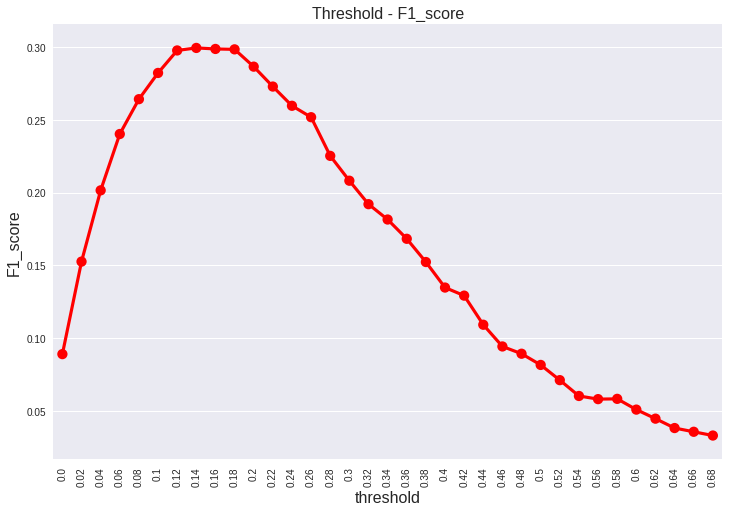

In [388]:
plt.figure(figsize=(12,8))
sns.pointplot(threshold, f_score_list, alpha=0.8, color='Red')
plt.ylabel('F1_score', fontsize=16)
plt.xlabel('threshold', fontsize=16)
plt.title("Threshold - F1_score", fontsize=16)
plt.xticks(rotation='vertical')
plt.show()